In [1]:
import xarray as xr
import numpy as np
from dask.distributed import Client

# artificial data

In [2]:
Nyear = 5
Nx = 36
Ny = 18

In [3]:
T = xr.DataArray(
    (
        2 * np.random.normal(size=(Nyear * 365, Ny, Nx))
        + 10 * np.sin(np.arange(Nyear * 365) / 365 * 2 * np.pi)[:, np.newaxis, np.newaxis]
        + 10
    ),
    dims=("t", "y", "x"),
    coords={"t": (("t", ), np.arange(Nyear * 365))},
    name="T",
)

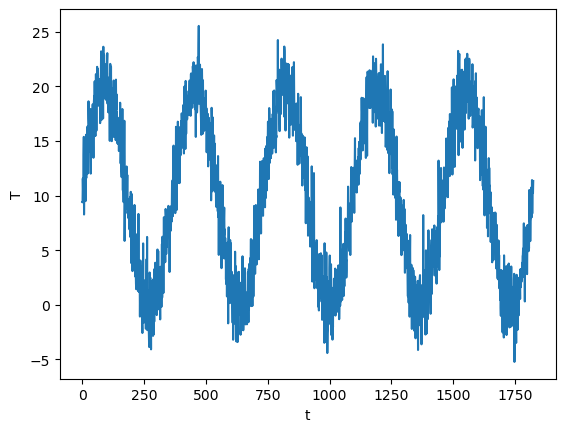

In [4]:
T.isel(x=0, y=0).plot()

In [5]:
T.to_dataset().to_netcdf("T.nc")

In [ ]:
!ncdump -h T.nc

In [ ]:
T = xr.open_dataset(
    "T.nc",
    chunks={"t": -1, "x": 6, "y": 6}
).T
T

In [ ]:
T.isel(x=0, y=0).plot()

In [ ]:
def clim(T):
    T = T.assign_coords(doy=T.t % 365)
    T_clim = T.groupby("doy").mean()
    T_clim = xr.concat(
        [T_clim for n in range(int(len(T.t) / 365))],
        dim="doy",
    ).rename({"doy": "t"})
    T_clim = T_clim.chunk({"t": -1})
    T_clim = (
        T_clim
        .assign_coords(doy=T.doy)
        .assign_coords(t=(("t", ), np.arange(Nyear * 365)))
    )
    return T_clim

In [ ]:
T_clim = clim(T)
T_clim

In [ ]:
T_clim.to_dataset().to_netcdf("T_clim.nc")

In [ ]:
T_clim = xr.open_dataset("T_clim.nc", chunks={"t": -1, "x": 6, "y": 6}).T
T_clim

In [ ]:
def clim_quant(T, T_clim=None, q=0.9):
    T = T.assign_coords(doy=T.t % 365)
    T = T - T_clim
    T_quant = T.groupby("doy").quantile(0.9)
    T_quant = xr.concat(
        [T_quant for n in range(int(len(T.t) / 365))],
        dim="doy",
    ).rename({"doy": "t"})
    T_quant = T_quant.chunk({"t": -1})
    T_quant = (
        T_quant
        .assign_coords(doy=T.doy)
        .assign_coords(t=(("t", ), np.arange(Nyear * 365)))
    )
    return T_quant

In [ ]:
T_quant = clim_quant(T, T_clim=T_clim, q=0.9)
T_quant

In [ ]:
T_quant.to_netcdf("T_quant.nc")

In [ ]:
T_quant = xr.open_dataset("T_quant.nc", chunks={"t": -1, "x": 6, "y": 6}).T
T_quant

In [ ]:
T_quant.isel(x=0, y=0).plot()

In [ ]:
def find_mhw_candidates(T, T_clim=None, T_thres=None, q=0.9):
    candidates = ((T - T_clim) / T_thres) > 1.0
    return candidates

In [ ]:
candidates = find_mhw_candidates(T, T_clim=T_clim, T_thres=T_quant, q=0.9)
candidates

In [ ]:
candidates.data.visualize()

In [ ]:
candidates.sum(["x", "y"]).plot()

## Dask

In [ ]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit=1e9)
client

In [ ]:
candidates.sum(["x", "y"]).plot()

## Forward iteration in tim

In [ ]:
def naive_cumulative_sum(data):
    s_buff = np.zeros_like(data[0, ...]).astype(int)
    s = []
    
    for n in range(data.shape[0]):
        s_buff = s_buff + data[n, ...].astype(int)
        s.append(s_buff.copy())
        
    return np.stack(s)

In [ ]:
naive_cumulative_sum(np.random.normal(size=(12, 3, 4))).sum(-1).sum(-1)

In [ ]:
%%time 

ncs_dask = naive_cumulative_sum(candidates.data)

In [ ]:
# ncs_dask.compute()

In [ ]:
%%time 

ncs_np = naive_cumulative_sum(candidates.compute().data)

In [ ]:
ncs_np[:, 0, 0]

In [ ]:
%%time 

ncs_ufunc = xr.apply_ufunc(
    naive_cumulative_sum,
    candidates.astype(int),
    input_core_dims=[["t", ], ],
    output_core_dims=[["t", ], ],
    output_dtypes=["float", ],
    dask="parallelized",
)

ncs_ufunc = ncs_ufunc.compute()

In [ ]:
ncs_ufunc.isel(x=0, y=0)  #.plot()